**Calculating free energy and probabilities**

In [1]:
from IPython.display import SVG
import RNA
import math
import random

In [2]:
# Global constants (R in kcal/(mol*K), T in Kelvin)
R_CONST = 0.0019872   # kcal/(mol*K)
T_CONST = 410.15      # ~37°C

In [3]:
# Create a fold compound for an RNA sequence
seq = "GCGCGAUACG"
fc = RNA.fold_compound(seq)

# Define a test structure (dot-bracket notation)
struct = "((....)).."

# Evaluate the free energy of the structure
energy = fc.eval_structure(struct)
print("Free energy: {:.2f} kcal/mol".format(energy))

Free energy: 6.40 kcal/mol


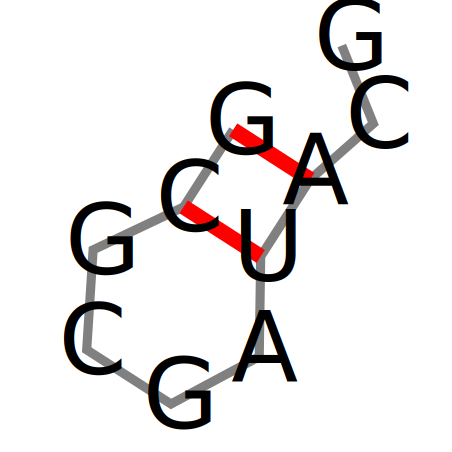

In [4]:
RNA.svg_rna_plot(seq, structure=struct, ssfile="tmp.svg")
SVG("tmp.svg")

In [5]:
def is_complementary(a, b):
    """Check if bases a and b are complementary."""
    valid_pairs = {('A','U'), ('U','A'), ('G','C'), ('C','G'), ('G','U'), ('U','G')}
    return (a, b) in valid_pairs

In [6]:
def dotbracket_to_pt(structure):
    """
    Convert a dot-bracket string to a pair table.
    Returns a list 'pt' of length n+1 (1-indexed; pt[0] is unused).
    For each i (1-indexed), pt[i] = j if base i is paired with j, else 0.
    """
    n = len(structure)
    pt = [0]*(n+1)
    stack = []
    for i, char in enumerate(structure, start=1):
        if char == '(':
            stack.append(i)
        elif char == ')':
            if stack:
                j = stack.pop()
                pt[i] = j
                pt[j] = i
    return pt

In [7]:
dotbracket_to_pt("((....))..")

[0, 8, 7, 0, 0, 0, 0, 2, 1, 0, 0]

In [8]:
def generate_moves(seq, structure):
    """
    Given a sequence and a current structure (in dot-bracket notation),
    generate every valid outcome with one base move (either addition or removal of a single base pair).
    
    Returns a list of tuples: (new_structure, move_type, (i, j))
    where move_type is either 'add' or 'remove', and (i, j) indicates the base pair changed.
    Positions are 1-indexed.
    """
    moves = []
    n = len(structure)
    # Convert structure to a pair table (1-indexed)
    pt = dotbracket_to_pt(structure)
    
    # --- Removal moves: remove an existing base pair ---
    # For every base i that is paired (and to avoid duplicates, ensure i < pt[i])
    for i in range(1, n+1):
        j = pt[i]
        if j > i:
            # Create new structure by removing the pair (i, j)
            new_struct = list(structure)
            new_struct[i-1] = '.'
            new_struct[j-1] = '.'
            moves.append((''.join(new_struct), 'remove', (i, j)))
    
    # --- Addition moves: add one new base pair ---
    # We consider all candidate pairs (i, j) with j - i >= 4 (minimum hairpin length constraint)
    for i in range(1, n+1):
        # Only consider i if currently unpaired
        if pt[i] != 0:
            continue
        for j in range(i+3, n+1):
            if pt[j] != 0:
                continue
            # Check if the bases are complementary
            if not is_complementary(seq[i-1], seq[j-1]):
                continue
            
            # Check that adding (i, j) does not cross any existing base pair.
            # For each existing base pair (k, l) (with k < l), ensure that both k and l lie entirely inside [i, j]
            # or entirely outside [i, j]. If one lies inside and the other outside, the new pair would cross.
            conflict = False
            for k in range(1, n+1):
                l = pt[k]
                if l > k:  # (k, l) is an existing pair
                    in_i = (i < k < j)
                    in_j = (i < l < j)
                    if in_i != in_j:
                        conflict = True
                        break
            if conflict:
                continue
            
            # Otherwise, adding (i, j) yields a valid structure.
            new_struct = list(structure)
            new_struct[i-1] = '('
            new_struct[j-1] = ')'
            moves.append((''.join(new_struct), 'add', (i, j)))
    
    return moves

In [15]:
def structure_distance(s1, s2):
    """
    Compute a simple Hamming distance between two dot-bracket strings.
    Assumes both strings are of the same length.
    """
    if len(s1) != len(s2):
        raise ValueError("Structures must be of equal length")
    return sum(1 for a, b in zip(s1, s2) if a != b)

In [9]:
generate_moves("GCGCUAUACG", "(..)......")

[('..........', 'remove', (1, 4)),
 ('(..)(..)..', 'add', (5, 8)),
 ('(..)(....)', 'add', (5, 10)),
 ('(..)..(..)', 'add', (7, 10))]

In [72]:
def move_probabilities(moves, end_struct, fc, T=T_CONST, beta=0):
    """
    Pour chaque mouvement dans 'moves' (liste de tuples (new_structure, move_type, (i, j))),
    calcule l'énergie libre à l'aide du fold compound 'fc' de ViennaRNA et retourne la probabilité
    associée à chaque mouvement selon la loi de Boltzmann.
    
    Renvoie une liste de probabilités correspondant aux mouvements.
    """
    energies = []
    for new_struct, move_type, pos in moves:
        # Calcule l'énergie libre de la structure résultante (en kcal/mol).
        E = fc.eval_structure(new_struct)
        energies.append(E)

    for k,(new_struct, move_type, pos) in enumerate(moves):
        m = structure_distance(new_struct, end_struct)
        energies[k] += beta*m
    
    # Détermination de l'énergie minimale pour factoriser les exponentielles
    E_min = min(energies)
    
    # Calcul des poids de Boltzmann en factorisant par l'énergie minimale.
    # Ainsi, weight = exp(- (E - E_min) / (R_CONST * T_CONST))
    weights = [math.exp(-(E - E_min) / (R_CONST * T)) for E in energies]
    
    total = sum(weights)
    probabilities = [w / total for w in weights]
    return probabilities


In [11]:
move_probabilities(generate_moves("GCGCUAUACG", "(..)(..).."), fc)

[0.5, 0.5]

In [77]:
def select_next_structure(seq, current_structure, end_struct, fc, T=T_CONST, beta=0):
    """
    Given a sequence and current structure, generate all one-base moves,
    compute their Boltzmann probabilities, and randomly select one move according
    to these probabilities.
    
    Returns the new structure and the move information (move_type, positions).
    If no moves are available, returns the current structure and None.
    """
    moves = generate_moves(seq, current_structure)
    if not moves:
        return current_structure, None
    probs = move_probabilities(moves, end_struct, fc, T=T, beta=beta)
    r = random.random()
    cumulative = 0.0
    for move, prob in zip(moves, probs):
        cumulative += prob
        if r <= cumulative:
            return move[0], (move[1], move[2])
    return moves[-1][0], (moves[-1][1], moves[-1][2])

In [13]:
# Create the ViennaRNA fold compound for our sequence.
fc = RNA.fold_compound(seq)
init_struct = ".........."

# 1) Generate all one-base moves
moves = generate_moves(seq, init_struct)
print("Generated Moves:")
for m in moves:
    print(m)

# 2) Compute probabilities for each move based on Boltzmann law
probs = move_probabilities(moves, fc)
print("\nMove Probabilities:")
for m, p in zip(moves, probs):
    print(f"Move: {m[1]} at positions {m[2]}, Structure: {m[0]}, Probability: {p:.4f}")

# 3) Randomly select the next structure using the computed probabilities
next_struct, move_info = select_next_structure(seq, init_struct, fc)
print("\nSelected Next Structure:")
print("Structure:", next_struct)
print("Move Info:", move_info)

Generated Moves:
('(..)......', 'add', (1, 4))
('(.....)...', 'add', (1, 7))
('(.......).', 'add', (1, 9))
('.(..).....', 'add', (2, 5))
('.(.......)', 'add', (2, 10))
('..(...)...', 'add', (3, 7))
('..(.....).', 'add', (3, 9))
('...(.....)', 'add', (4, 10))
('....(...).', 'add', (5, 9))
('......(..)', 'add', (7, 10))

Move Probabilities:
Move: add at positions (1, 4), Structure: (..)......, Probability: 0.0000
Move: add at positions (1, 7), Structure: (.....)..., Probability: 0.0203
Move: add at positions (1, 9), Structure: (.......)., Probability: 0.3023
Move: add at positions (2, 5), Structure: .(..)....., Probability: 0.0000
Move: add at positions (2, 10), Structure: .(.......), Probability: 0.0784
Move: add at positions (3, 7), Structure: ..(...)..., Probability: 0.0159
Move: add at positions (3, 9), Structure: ..(.....)., Probability: 0.3417
Move: add at positions (4, 10), Structure: ...(.....), Probability: 0.1133
Move: add at positions (5, 9), Structure: ....(...)., Probability

In [14]:
def init_population(seq, start_struct, N):
    """
    Initiate a population of size N.
    Each individual is a dictionary with keys:
      'structure': the current dot-bracket structure
      'distance': the current distance to the end structure (initialized to None)
    Since sequence remains fixed, we only evolve the structure.
    """
    population = []
    for _ in range(N):
        individual = {
            'structure': start_struct,
            'distance': 1,  # will be updated later
            'highest_energy': 0
        }
        population.append(individual)
    return population

In [83]:
def evolve_population_inclusive(population, seq, fc, start_struct, end_struct, alpha=0.7, T=T_CONST, beta=0):
    """
    For each individual in the current population, perform one evolutionary step
    to generate a new candidate via a one-base move. Then, combine the new candidates
    with the original population and select the best N individuals (those with the smallest
    distance to the end structure).
    
    Returns the new population.
    """
    N = len(population)
    new_candidates = []
    
    # Generate new candidates for each individual
    for individual in population:
        current_struct = individual['structure']
        next_struct, _ = select_next_structure(seq, current_struct, end_struct, fc, T=T, beta=beta)
        dist = structure_distance(next_struct, end_struct)
        candidate = {
            'structure': next_struct,
            'distance': dist,
            'highest_energy': max(individual['highest_energy'], fc.eval_structure(individual['structure'])-fc.eval_structure(start_struct))
        }
        new_candidates.append(candidate)
    
    # Update original population with their current distance
    current_with_distance = []
    for ind in population:
        d = structure_distance(ind['structure'], end_struct)
        current_with_distance.append({
            'structure': ind['structure'],
            'distance': d,
            'highest_energy': ind['highest_energy']
        })
    
    # Combine the old population with the new candidates
    combined = new_candidates + current_with_distance
    
    # Sort by distance (lower is better) and keep the best N individuals
    combined.sort(key=lambda ind: (ind['distance'], ind['highest_energy']))
    #new_population = combined[:N]

    best_count = int(alpha * N)
    random_count = N - best_count

    # Keep the best alpha% individuals
    best_individuals = combined[:best_count]

    # Select N/3 individuals at random among the remaining ones
    remaining_individuals = combined[N:]
    random_individuals = random.sample(remaining_individuals, random_count)

    # Create the new population by combining the best and random individuals
    new_population = best_individuals + random_individuals
    
    return new_population

In [36]:
def compute_barrier(population):
    """
    Compute the highest energy barrier encountered by the population.
    """
    for ind in population:
        if ind['distance'] == 0:
            return ind['highest_energy']

In [37]:
# Example data:
seq = "GGGGAAACUCC"
start_struct = "(..(...)..)"
end_struct = "...((...))."  # target structure

# Create a fold compound for the sequence (ViennaRNA initialization)
fc = RNA.fold_compound(seq)

# 1. Initialize population of size N
N = 100
population = init_population(seq, start_struct, N)

# Let's run evolution for a number of steps and print progress
max_steps = 100
step = 0
print("Generation 0:")
# for ind in population:
#     d = structure_distance(ind['structure'], end_struct)
#     print(f"Structure: {ind['structure']}, Distance: {d}")

while step<max_steps and compute_barrier(population) is None:
    step += 1
    population = evolve_population_inclusive(population, seq, fc, start_struct, end_struct)
    # For reporting, update distances and print
    print(f"\nGeneration {step}:")
    #for ind in population:
        #print(f"Structure: {ind['structure']}, Distance: {ind['distance']}, Move: {ind['move_info']}")

# Optionally, report the best candidate at the final generation:
best = min(population, key=lambda ind: ind['distance'])
print("\nBest candidate after evolution:")
print(f"Structure: {best['structure']}, Distance: {best['distance']}, Energy barrier: {best['highest_energy']} kcal/mol")
print(f"Energy barrier: {compute_barrier(population)} kcal/mol")

Generation 0:

Generation 1:

Generation 2:

Generation 3:

Generation 4:

Generation 5:

Generation 6:

Generation 7:

Generation 8:

Generation 9:

Best candidate after evolution:
Structure: ...((...))., Distance: 0, Energy barrier: 0 kcal/mol
Energy barrier: 0 kcal/mol


In [79]:
# Example data 2:
seq = "ACACGACCUCAUAUAAUCUUGGGAAUAUGGCCCAUAAGUUUCUACCCGGCAACCGUAAAUUGCCGGACUAUGCAGGGAAGUG"
start_struct = "......................(....................)....(.............)..................."
end_struct = ".(((..(((((((......((((.......))))...........(((((((.......)))))))..)))).)))...)))"  # target structure

# Create a fold compound for the sequence (ViennaRNA initialization)
fc = RNA.fold_compound(seq)

# 1. Initialize population of size N
N = 100
population = init_population(seq, start_struct, N)

max_steps = 500
step = 0
print("Generation 0:")
# for ind in population:
#     d = structure_distance(ind['structure'], end_struct)
#     print(f"Structure: {ind['structure']}, Distance: {d}")

while step<max_steps and compute_barrier(population) is None:
    step += 1
    population = evolve_population_inclusive(population, seq, fc, start_struct, end_struct)
    # For reporting, update distances and print
    print(f"\nGeneration {step}:")
    print(population[0])
    #for ind in population:
        #print(f"Structure: {ind['structure']}, Distance: {ind['distance']}, Move: {ind['move_info']}")

best = min(population, key=lambda ind: ind['distance'])
print("\nBest candidate after evolution:")
print(f"Structure: {best['structure']}, Distance: {best['distance']}, Energy barrier: {best['highest_energy']} kcal/mol")
print(f"Number of steps necessary to reach the target structure: {step}")

Generation 0:

Generation 1:
{'structure': '......................(....................)...((.............))..................', 'distance': 38, 'highest_energy': 0}

Generation 2:
{'structure': '......................(....................)...(((...........)))..................', 'distance': 36, 'highest_energy': 0}

Generation 3:
{'structure': '...............................................(((...........)))..................', 'distance': 36, 'highest_energy': 0}

Generation 4:
{'structure': '..............................................((((...........)))).................', 'distance': 34, 'highest_energy': 0}

Generation 5:
{'structure': '.............................................(((((...........)))))................', 'distance': 32, 'highest_energy': 0}

Generation 6:
{'structure': '.............................................((((((.........))))))................', 'distance': 30, 'highest_energy': 0}

Generation 7:
{'structure': '............................................

Idées:

Changer la température
Faire du transfert learning
Mettre une pénalité suivant la distance ?, l'énergie


In [81]:
def best_folding(seq, start_struct, end_struct, alpha = 0.7, N = 100, max_steps = 100, T=T_CONST, beta=0):
    """
    Given a sequence, start and end structures, evolve a population of structures
    to find the one with the smallest distance to the end structure.
    """
    # Create a fold compound for the sequence (ViennaRNA initialization)
    fc = RNA.fold_compound(seq)

    # 1. Initialize population of size N
    population = init_population(seq, start_struct, N)

    step = 0
    while step<max_steps and compute_barrier(population) is None:
        step += 1
        population = evolve_population_inclusive(population, seq, fc, start_struct, end_struct, alpha=alpha, T=T, beta=beta)
        if step % 10 == 0:
            print(f"\nGeneration {step}:")
            print(population[0])
    
    best = min(population, key=lambda ind: (ind['distance'], ind['highest_energy']))
    return best, step

In [84]:
best_folding(seq, end_struct, start_struct, N=100, max_steps=100, alpha=0.3, T=T_CONST, beta=10)


Generation 10:
{'structure': '......(((...........(((.......)))............(((((...........))))).......)))......', 'distance': 20, 'highest_energy': 9.300000190734863}

Generation 20:
{'structure': '......................(.......).................(.............)...................', 'distance': 2, 'highest_energy': 26.40000009536743}

Generation 30:
{'structure': '......................(.......).................(.............)...................', 'distance': 2, 'highest_energy': 26.40000009536743}

Generation 40:
{'structure': '......................(.......).................(.............)...................', 'distance': 2, 'highest_energy': 26.40000009536743}

Generation 50:
{'structure': '......................(.......).................(.............)...................', 'distance': 2, 'highest_energy': 26.40000009536743}

Generation 60:
{'structure': '......................(.......).................(.............)...................', 'distance': 2, 'highest_energy': 26.4000000

({'structure': '......................(.......).................(.............)...................',
  'distance': 2,
  'highest_energy': 26.40000009536743},
 100)